# MODEL RUN

In [78]:
import os

os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

from transformers import GPT2LMHeadModel, AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("gpt2")
tokenizer.pad_token = tokenizer.eos_token

from torch import nn
import torch


def compute_loss_labelsmoothed(logits, labels, ignore_index=-100, epsilon=0.1):
    logits = logits[..., :-1, :].contiguous()
    labels = labels[..., 1:].contiguous()

    log_probs = -nn.functional.log_softmax(logits, dim=-1)
    if labels.dim() == log_probs.dim() - 1:
        labels = labels.unsqueeze(-1)

    padding_mask = labels.eq(ignore_index)

    labels = torch.clamp(labels, min=0)
    nll_loss = log_probs.gather(dim=-1, index=labels)

    smoothed_loss = log_probs.sum(dim=-1, keepdim=True, dtype=torch.float32)

    nll_loss.masked_fill_(padding_mask, 0.0)
    smoothed_loss.masked_fill_(padding_mask, 0.0)

    num_active_elements = padding_mask.numel() - padding_mask.long().sum()
    nll_loss = nll_loss.sum() / num_active_elements
    smoothed_loss = smoothed_loss.sum() / (num_active_elements * log_probs.shape[-1])
    return (1 - epsilon) * nll_loss + epsilon * smoothed_loss

    
class MyNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.transformer = GPT2LMHeadModel.from_pretrained('gpt2')
        
        hid_size = self.transformer.config.n_embd
        self.voc_size = self.transformer.config.vocab_size
        
        self.early_exits = nn.ModuleList([
            nn.Linear(hid_size, self.voc_size) for _ in range(self.transformer.config.n_layer - 1)
        ])
        
        self.ce = nn.CrossEntropyLoss()
    
    def forward(self, input_ids, attention_mask, labels=None):
        output = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels,
            output_hidden_states=True,
        )
        
        hidden_states = output.hidden_states[1:-1]
        
        heads_outputs = [
            self.early_exits[idx](hidden_states[idx])
            for idx in range(len(self.early_exits))
        ]
                
        if labels is None:
            heads_outputs = [
                torch.softmax(head_output, dim=-1) for head_output in heads_outputs
            ] 

            return {'head_outputs': heads_outputs, 'last_head': torch.softmax(output.logits, dim=-1)}
        
        
        losses = [
            compute_loss_labelsmoothed(head_output, labels)
            for head_output in heads_outputs
        ]
        
        losses = torch.stack(losses,)
        total_loss = torch.sum(losses)
        
        heads_outputs = [
            torch.softmax(head_output, dim=-1) for head_output in heads_outputs
        ]
        return {
            'loss': total_loss, 
            'head_outputs': heads_outputs,
            'last_head': torch.softmax(output.logits, dim=-1),
        }
        

2023-02-24 09:06:23.797641: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-24 09:06:24.020961: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-02-24 09:06:26.135676: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/local/cuda/extras/CUPTI/lib64:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/

In [79]:
from transformers import DataCollatorForLanguageModeling

collator = DataCollatorForLanguageModeling(tokenizer, mlm=False)

net = MyNet().to('cuda')
net = net.eval()

In [80]:
from transformers import Trainer

In [ ]:
net.load_state_dict(torch.load('files/pytorch_model.bin'))

In [ ]:
net.eval();

### получаем тестовый датасет

In [6]:
dataset_path = 'files/dataset_test'
dataset_cache = 'files/.cache'

In [7]:
from datasets import load_dataset
import numpy as np

# dataset = load_dataset("wikipedia", "20220301.en", dataset_cache)

# rand_idx = np.random.choice(np.arange(len(dataset['train'])), size=100_000, replace=False)

# # import json
# # rand_idx = json.load(open('indices.json', 'r'))

# dataset = dataset['train'].select(rand_idx, )

# # # import json

# # # json.dump(rand_idx.tolist(), open('indices.json', 'w'),)

# # def tokenize_data(example):
# #     return tokenizer(example['text'], max_length=512, truncation=True)

# # dataset = dataset.map(
# #     tokenize_data, remove_columns=['text', 'id', 'url', 'title'], batched=True, num_proc=10
# # )

# dataset.save_to_disk(dataset_path)


from datasets import load_from_disk

dataset = load_from_disk(dataset_path)

In [8]:
dataset

Dataset({
    features: ['id', 'url', 'title', 'text'],
    num_rows: 100000
})

In [9]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

In [10]:
from collections import defaultdict

In [11]:
from transformers import GPT2TokenizerFast

tokenizer = GPT2TokenizerFast.from_pretrained("gpt2", add_prefix_space=True)

In [12]:
@torch.inference_mode()
def get_sentence_probs(sent):
    words = sent.lower().split()
    
    tokenized = tokenizer(
        words, truncation=True, max_length=512, is_split_into_words=True, return_tensors='pt'
    ).to('cuda')
    
    outputs = net(**tokenized)
    
    heads_probs = outputs['head_outputs'] + [outputs['last_head']]
    heads_probs = torch.stack(heads_probs)  # [num_layers, 1, seq_len, voc_size]
    
    return_dict = defaultdict(lambda: defaultdict(list))
    
    word_ids = tokenized.word_ids()
    
    heads_preds_per_words = []
    for i in range(len(word_ids) - 1):
        word_id = word_ids[i + 1]
                
        gt_token_id = tokenized['input_ids'][0, i + 1]
        heads_predictions = heads_probs[:, 0, i, gt_token_id].cpu().numpy()
        
        heads_preds_per_words.append(heads_predictions)
    
    prev_word_id = 0
    cur_prob = np.zeros(*heads_preds_per_words[0].shape) # [num_layers, ]
    cur_count = 0
    
    
    for i in range(len(word_ids) - 1):
        word_id = word_ids[i + 1]
        heads_prediction = heads_preds_per_words[i] # [num_layers, ]
        
        if word_id == prev_word_id:
            cur_count += 1
            for layer in range(12):
                cur_prob[layer] += heads_prediction[layer]
        else:
        
            word_key = lemmatizer.lemmatize(words[word_id])

            for layer in range(len(heads_predictions)):
                return_dict[word_key][layer].append(cur_prob[layer] / cur_count)
            
            cur_prob = heads_prediction
            cur_count = 1
            
    for k, v in return_dict.items():
        for kv, arrs in v.items():
            return_dict[k][kv] = np.mean(np.stack(arrs), axis=0)
            
    return return_dict
    # {word: {layer: [probs, ...]}}

In [13]:
from tqdm.auto import tqdm

In [14]:
word_stats = defaultdict(lambda: defaultdict(list))

for i in tqdm(range(10_000)):
    example = dataset[i]
    
    return_dict = get_sentence_probs(example['text'])
    
    for word in return_dict.keys():
        for layer in return_dict[word].keys():
            word_stats[word][layer].append(return_dict[word][layer])

  0%|          | 0/10000 [00:00<?, ?it/s]

/tmp/ipykernel_26643/2222946174.py:45: RuntimeWarning: invalid value encountered in double_scalars
  return_dict[word_key][layer].append(cur_prob[layer] / cur_count)


In [15]:
import joblib

In [16]:
word_stats_dict = {k: dict(v) for k, v in word_stats.items()}

In [ ]:
joblib.dump(word_stats_dict, 'files/word_stats_dict.joblib')

_______

# ANALYSE

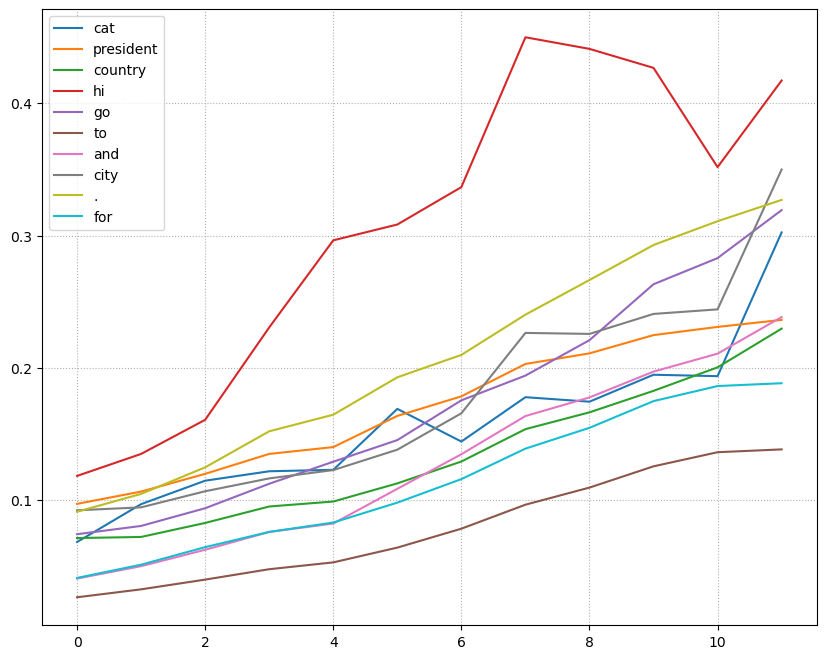

In [1]:
import joblib

word_stats = joblib.load('files/word_stats_dict.joblib')

import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(10, 8))

# plt.yscale('log')

for word in ['cat', 'president', 'country', 'hi', 'go', 'to', 'and', 'I', 'city', '.', 'for']:
    if word not in word_stats:
        continue
        
    stats = word_stats[word]
    to_draw = [np.mean(np.nan_to_num(layer_stat)) for layer_stat in stats.values()]
    plt.plot(np.arange(len(stats)), to_draw, label=word)

plt.grid(ls=':')
plt.legend()

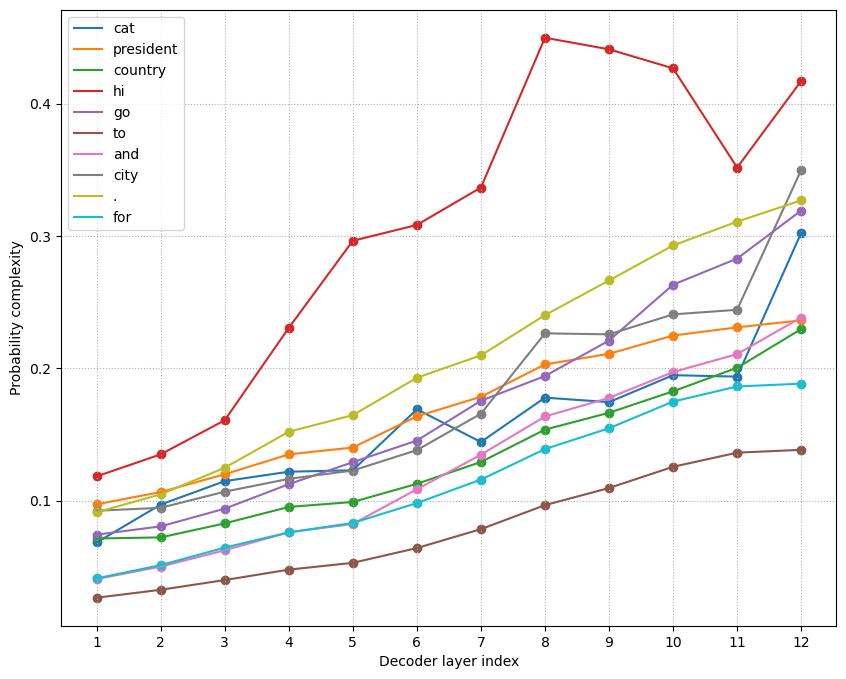

In [5]:
import joblib

# word_stats = joblib.load('files/word_stats_dict.joblib')

import matplotlib.pyplot as plt

import numpy as np

plt.figure(figsize=(10, 8))

# plt.yscale('log')

for word in ['cat', 'president', 'country', 'hi', 'go', 'to', 'and', 'I', 'city', '.', 'for']:
    if word not in word_stats:
        continue
        
    stats = word_stats[word]
    to_draw = [np.mean(np.nan_to_num(layer_stat)) for layer_stat in stats.values()]
    plt.plot(np.arange(len(stats)) + 1, to_draw, label=word)
    plt.scatter(np.arange(len(stats)) + 1, to_draw)

plt.xlabel('Decoder layer index')
plt.ylabel('Probability complexity')
plt.xticks(np.arange(len(stats)) + 1, np.arange(len(stats)) + 1)
plt.grid(ls=':')
plt.legend()

In [13]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from pylab import rcParams

def plot_box(word):
    probs, layer = [], []
    for i in range(12):
        for prob in word_stats[word][i]:
            if prob is not None:
                probs.append(prob)
                layer.append(i)
    data = pd.DataFrame({'Probability Complexity': probs, 'Decoder Layer': layer})
    plt.figure(figsize=(10, 10))
    plt.title(word)
    sns.boxplot(x='Probability Complexity', y='Decoder Layer', data=data, orient='h')
    plt.grid(ls=':')
    plt.show()

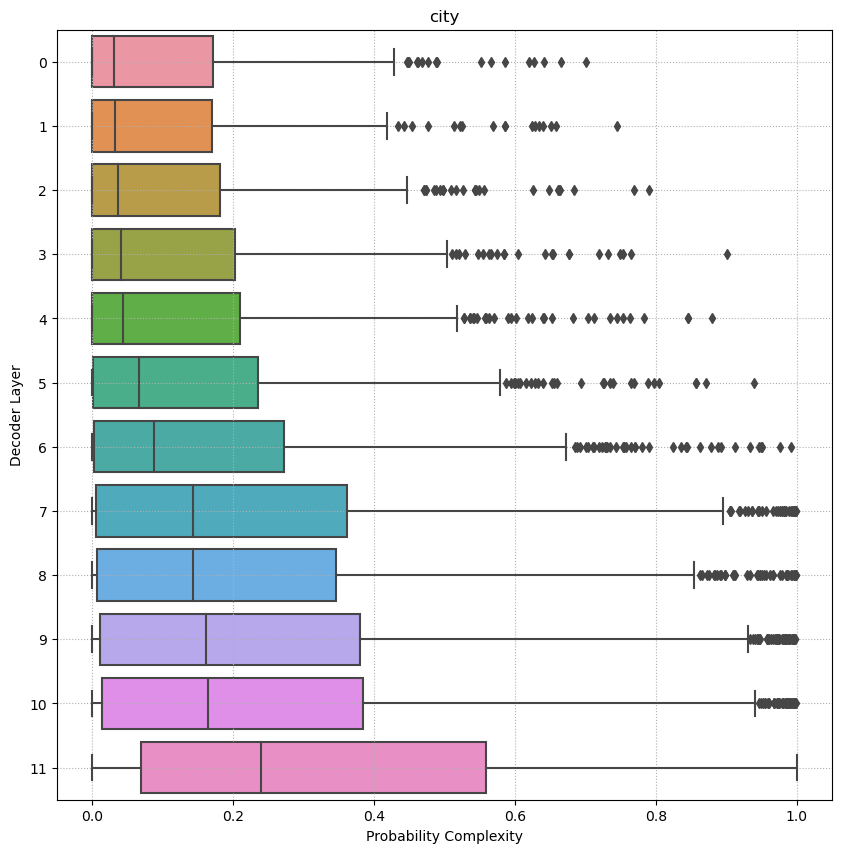

In [14]:
plot_box('city')

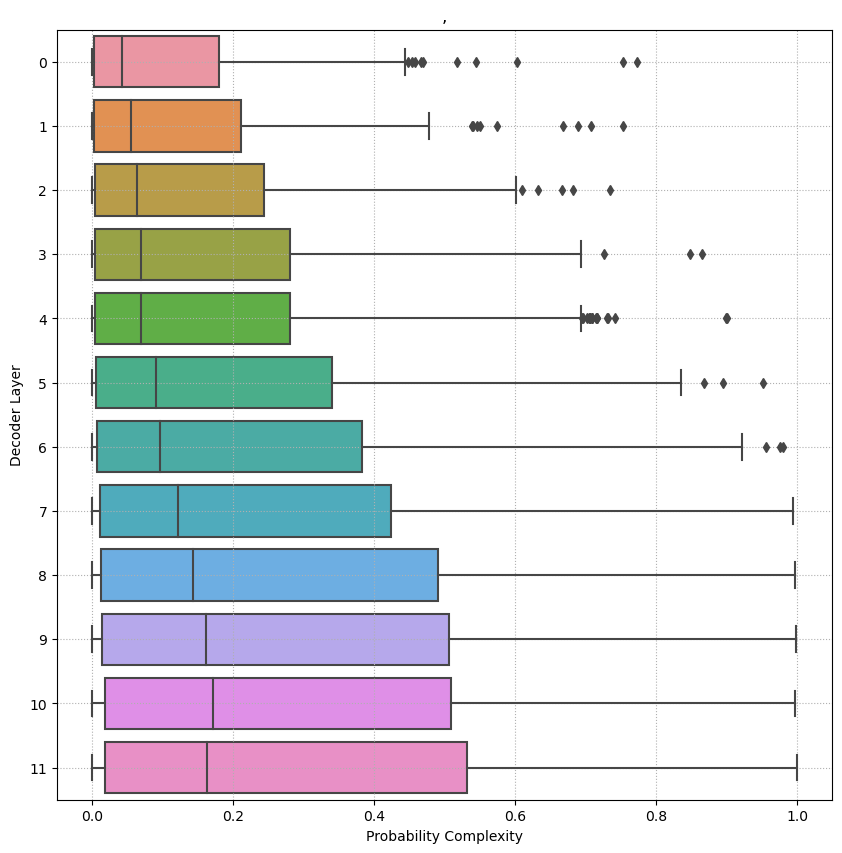

In [15]:
plot_box(',')

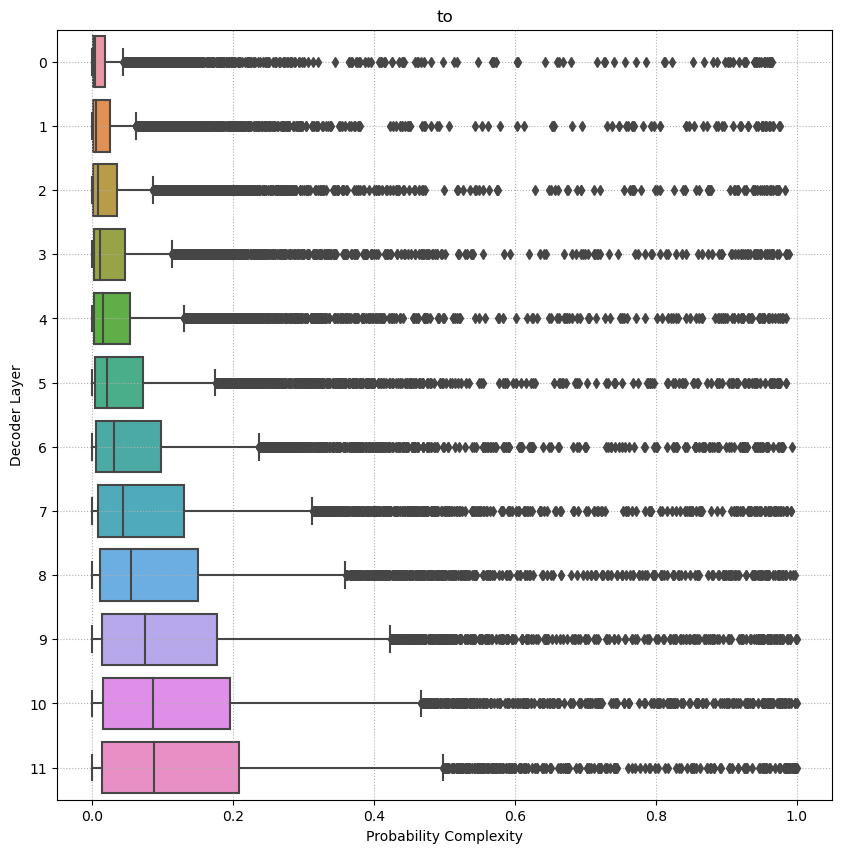

In [16]:
plot_box('to')

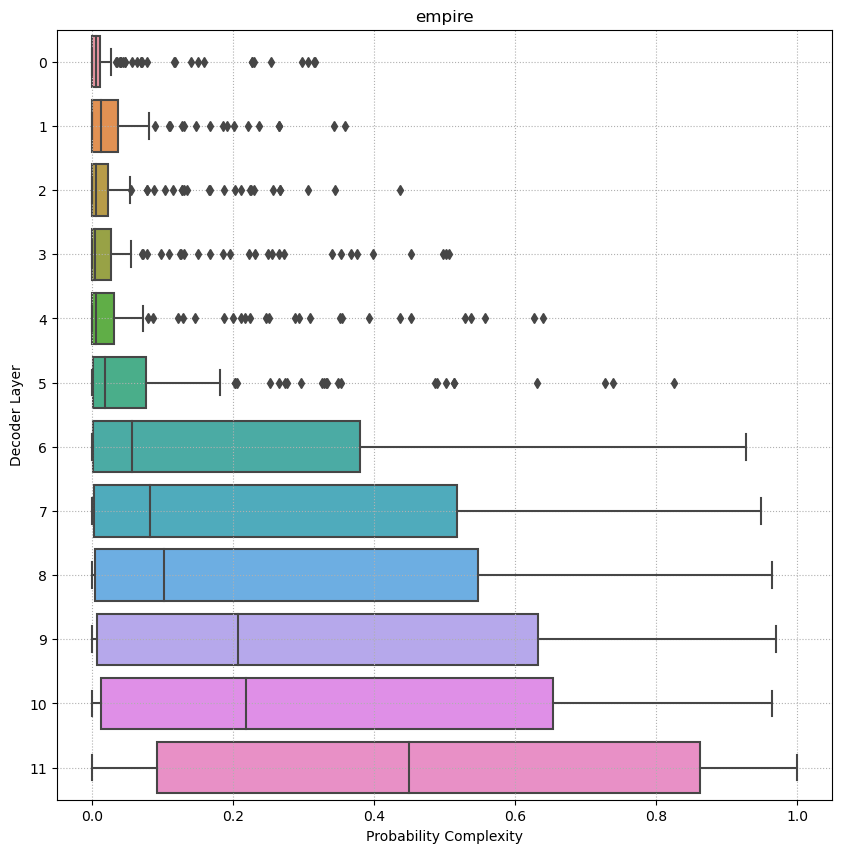

In [17]:
plot_box('empire')

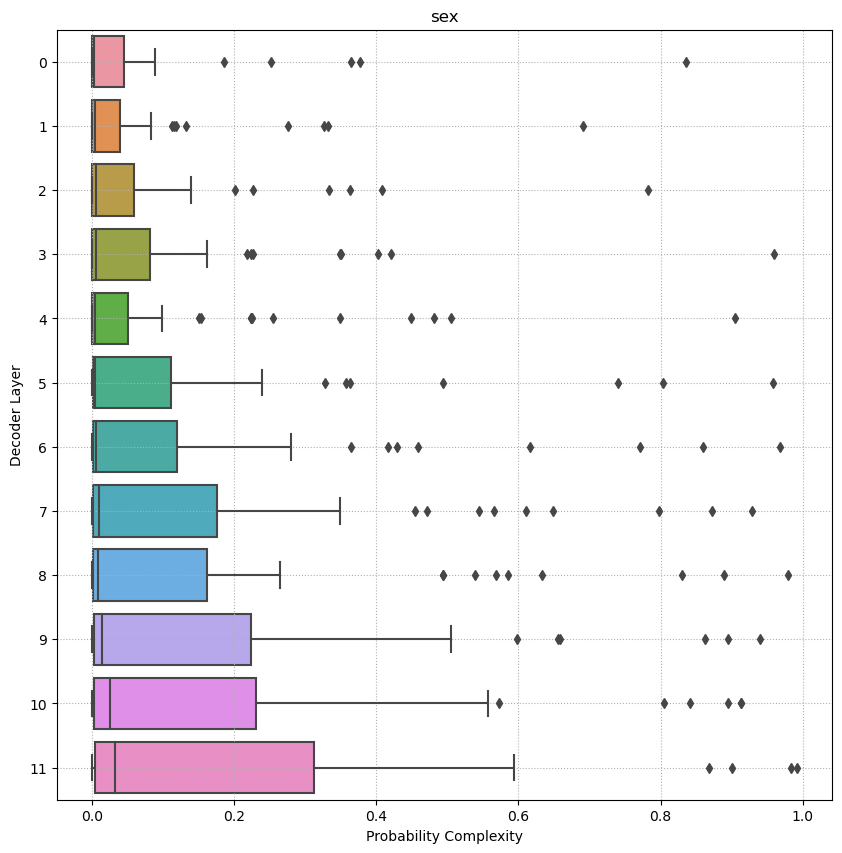

In [18]:
plot_box('sex')

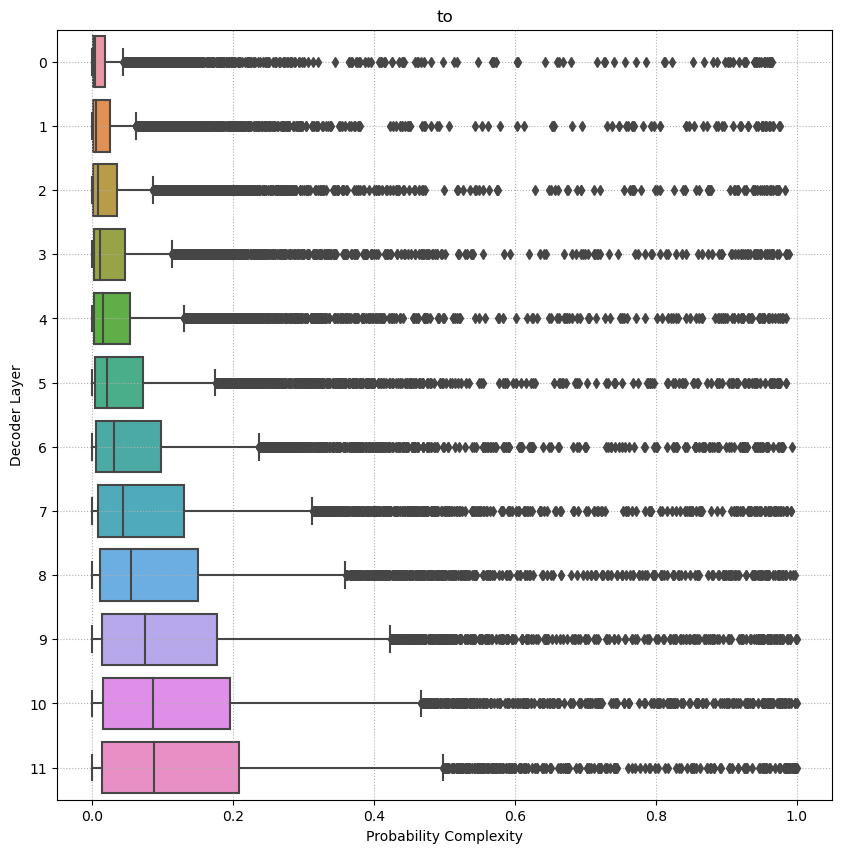

In [21]:
plot_box('to')

### Смотрим вероятности модели

In [23]:
def mean_prob_for_layer(layer, count_th=1):

    all_probs = 0
    all_words = 0

    for k in word_stats:
        if len(word_stats[k][11]) > count_th: 
            all_probs += sum(np.nan_to_num(word_stats[k][layer]))
            all_words += len(np.nan_to_num(word_stats[k][layer]))
    
    return all_probs / all_words

layer = 11

for layer in range(12):
    print(f'Средняя вероятность c которой GPT предсказывает слово на слое {layer + 1}:', mean_prob_for_layer(layer))

Средняя вероятность c которой GPT предсказывает слово на слое 1: 0.058293671960873074
Средняя вероятность c которой GPT предсказывает слово на слое 2: 0.06698115316835129


KeyboardInterrupt: 

In [ ]:
xs = [mean_prob_for_layer(layer) for layer in range(12)]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


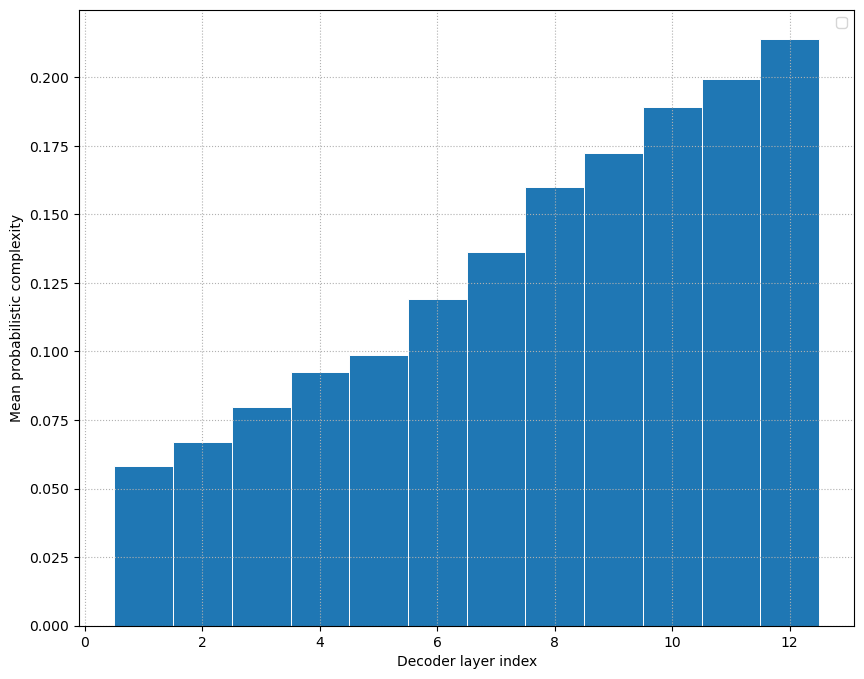

In [26]:
plt.figure(figsize=(10, 8))
plt.legend()

plt.bar(np.arange(12) + 1, xs, width=1, edgecolor="white", linewidth=0.7)

plt.xlabel('Decoder layer index')
plt.ylabel('Mean probabilistic complexity')
plt.grid(ls=':')
plt.show()

Посмотрим для часто встречающихся слов

In [38]:
for layer in range(12):
    print(f'Средняя вероятность c которой GPT предсказывает слово на слое {layer + 1}:', mean_prob_for_layer(layer, 50))

Средняя вероятность c которой GPT предсказывает слово на слое 1: 0.06299346585089008
Средняя вероятность c которой GPT предсказывает слово на слое 2: 0.07258940107846186
Средняя вероятность c которой GPT предсказывает слово на слое 3: 0.08587495447784149
Средняя вероятность c которой GPT предсказывает слово на слое 4: 0.09950223178208592
Средняя вероятность c которой GPT предсказывает слово на слое 5: 0.1057818123715835
Средняя вероятность c которой GPT предсказывает слово на слое 6: 0.12602385471660965
Средняя вероятность c которой GPT предсказывает слово на слое 7: 0.14359573494286423
Средняя вероятность c которой GPT предсказывает слово на слое 8: 0.1672411716502503
Средняя вероятность c которой GPT предсказывает слово на слое 9: 0.17927050058394506
Средняя вероятность c которой GPT предсказывает слово на слое 10: 0.1957206843962703
Средняя вероятность c которой GPT предсказывает слово на слое 11: 0.2050413126082107
Средняя вероятность c которой GPT предсказывает слово на слое 12: 0

Видим, что она не сильно отличается от усреднения по всем токенам

In [48]:
mean_probs = {k: {l: np.mean(np.nan_to_num(word_stats[k][l])) for l in word_stats[k]} for k in word_stats}

In [51]:
word = 'president'

def print_word_by_layer_stat(word):
    for layer in range(12):
        print(
            f'Средняя вероятность предсказать слово {word} на слое {layer + 1}:', 
            mean_probs[word][layer],
        )

In [52]:
word = 'president'
print_word_by_layer_stat(word)

Средняя вероятность предсказать слово president на слое 1: 0.09713721097490159
Средняя вероятность предсказать слово president на слое 2: 0.10641415556260855
Средняя вероятность предсказать слово president на слое 3: 0.11982719386238055
Средняя вероятность предсказать слово president на слое 4: 0.1348904199566825
Средняя вероятность предсказать слово president на слое 5: 0.1400588304762486
Средняя вероятность предсказать слово president на слое 6: 0.16361451941259345
Средняя вероятность предсказать слово president на слое 7: 0.17842379961325713
Средняя вероятность предсказать слово president на слое 8: 0.20288914464895588
Средняя вероятность предсказать слово president на слое 9: 0.21091215355460688
Средняя вероятность предсказать слово president на слое 10: 0.22472528944668999
Средняя вероятность предсказать слово president на слое 11: 0.2309144530621909
Средняя вероятность предсказать слово president на слое 12: 0.23620452363475727


In [53]:
word = 'cat'
print_word_by_layer_stat(word)

Средняя вероятность предсказать слово cat на слое 1: 0.0682896133364135
Средняя вероятность предсказать слово cat на слое 2: 0.09692882563939693
Средняя вероятность предсказать слово cat на слое 3: 0.11464491015704797
Средняя вероятность предсказать слово cat на слое 4: 0.12177460757245834
Средняя вероятность предсказать слово cat на слое 5: 0.12286890314053105
Средняя вероятность предсказать слово cat на слое 6: 0.1689532263923673
Средняя вероятность предсказать слово cat на слое 7: 0.14424419304220437
Средняя вероятность предсказать слово cat на слое 8: 0.17777576504168435
Средняя вероятность предсказать слово cat на слое 9: 0.17437464574788575
Средняя вероятность предсказать слово cat на слое 10: 0.19475507260551073
Средняя вероятность предсказать слово cat на слое 11: 0.19367198392165078
Средняя вероятность предсказать слово cat на слое 12: 0.3023607263350641


1. ox зафиксировать
2. бокс плоты для разных чекпоинтов сравнить
3. посчитать градиенты без обновления модели, если большие -> она не видела такого много ей надо сильно обновится. Насколько был большой лосс итд
4. наивно кореляция (частота, градиенты)
5. кластеризация tf-idf и смотреть на сложность группы например (readibility посмотреть методы)
6. взять корпусы других доменов и посмотреть domen specific слова или сложность группы
7. distil посмотреть распределения вероятностей на слоях--дистилировали и допустим сложность групп каких увеличилась




По сути надо про методы говорить и про практические применения (domen specific, model correlation)


### Приколы с градиентами

на слове и соседних словах посмотреть какие градиенты

насколько норма в целом бывает разная 

посмотреть параметр его диапазон что происходит

1) выделить подмжнодество весов и последить за этими весами на словах других, вдруг там есть корреляция между словами. Вдруг это просто кусок модели которому нужно еще учиться

2) разделить подмножетсво на тест и аналитику

3) сделать нармальный пайплайн для тестирования всего этого 

4) language visualisation tool

In [ ]:
net

In [ ]:
# head_outputs[i][bs][seqlen][tok_num] = P(из i-го слоя на seqlen месте стоит токен tok_num) -- как у нас щас
# пример: хотим взять для 5го токена градиенты из первой головы
 
head_outputs = model(**tokenized_input)['head_outputs']
 
# готовим вероятности
ho = heads_output[1]
token_probs = ho[:, 5 - 1] # предсказание для этого токена
token = tokenized_input['input_ids'][:, 5] # само значение токена
 
loss_fn = torch.nn.CrossEntropyLoss()
 
loss = loss_fn(token_probs, token, )
 
optimizer = torch.optim.Adam(model.parameters())
optimizer.zero_grad()
loss.backward()
 
for param_name, param in model.named_parameters():
    print(f'gradient for {param_name} =', param.grad)



In [ ]:
# полезно брать норму градиентов и сравнивать ее с большой / маленькой
total_norm = 0
for p in model.parameters():
    param_norm = p.grad.data.norm(2)
    total_norm += param_norm.item() ** 2
total_norm = total_norm ** (1. / 2)
 